In [166]:
from scipy import *
import WLanalysis
import cPickle as pickle
import camb
from camb import model, initialpower
from astropy.cosmology import FlatLambdaCDM
from scipy import optimize,stats
import os 
import numpy as np
import sys
import astropy.units as u
from scipy import interpolate
from scipy.integrate import quad
from IPython.display import Image
from matplotlib.patches import Ellipse

ERROR! Session/line number was not unique in database. History logging moved to new session 1356


In [167]:
def plotEllipse(pos,P,edge,ls,ilabel,ax):
    '''plot the contour for covariance p
    where position is the center position
    p is the covariance [2,2] matirx'''
    U, s, Vh = svd(P) 
    orient = math.atan2(U[1,0],U[0,0])*180/pi
    ellipsePlot = Ellipse(xy=pos, width=2.0*math.sqrt(s[0]), 
                          height=2.0*math.sqrt(s[1]), angle=orient,edgecolor=edge, fill = 0, label=ilabel,ls=ls,linewidth=1.5)
    ax.add_patch(ellipsePlot)
    return ellipsePlot

In [168]:
fn_list = genfromtxt('cosmo_params_all.txt',usecols=1, dtype='string')
fidu_cosmo = fn_list[0]

In [3]:
params = genfromtxt('cosmo_params_all.txt',usecols=[2,3,4,5]) #M_nu Omega_m 10^9*A_s sigma_8

In [4]:
z_source = arange(0.5,3,0.5)
ps_arr = array([[mean(load('powerspectrum_noiseless/%s_PS_50_z%02d.npy'%(icosmo,iz*10))[1:],axis=0) for icosmo in fn_list] for iz in z_source])
#save('ps_arr.npy', ps_arr)
#ps_arr = load('ps_arr.npy')
ps_fidu = array([load('powerspectrum_noisy/%s_PS_50_z%02d.npy'%(fidu_cosmo,iz*10))[1:]  for iz in z_source])
ell_fidu = array([load('powerspectrum_noisy/%s_PS_50_z%02d.npy'%(fidu_cosmo,iz*10))[0]  for iz in z_source])
ds = pickle.load(open("pickled_derivatives_powers.pkl",'rb'))

In [5]:
ell_mat = arange(5000)
#{'tau': 0.06, 'H0': 67.0, 'mnu': 0.1, 'As': 2.2e-09, 'omch2': 0.1247, 'w0': -1.0, 'ns': 0.96, 'ombh2': 0.0223}
#{'tau': 0.00, 'H0': 70.0, 'mnu': 0.1, 'As': 2.1e-09, 'omch2': 0.1247, 'w0': -1.0, 'ns': 0.97, 'ombh2': 0.0223}
#ds['As'][0,0].shape 
#ds['mnu'][0,0] is dC00/dmnu
#Clnn=0.35**2 / ngal / 1.18e7
#dCell/dmnu = (C(mnu+step/2.)-(mnu-step/2.))/step
dcldmnu_mat = array([ds['mnu'][i,i] for i in range(5)])
dcldmnu_mat.shape

(5, 5000)

In [6]:
print ps_arr.shape, params.shape,ps_fidu.shape, ell_fidu.shape

(5, 101, 50) (101, 4) (5, 1000, 50) (5, 50)


In [7]:
ps_all = [WLanalysis.buildInterpolator(ps_arr[i], params[:,:-1]) for i in range(5)]

In [8]:
ps_fidu_avg = mean(ps_fidu,axis=1)
ps_fidu_avg.shape

(5, 50)

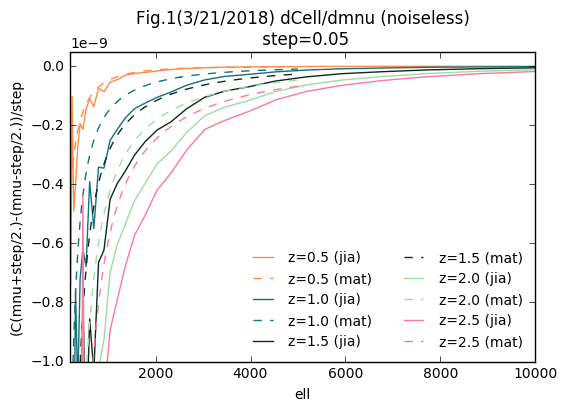

In [9]:
istep = 0.05
ps_hi = array ( [ps_all[i]( (0.1 * (1+istep/2), 0.3, 2.1))  for i in range(5)])
ps_lo = array ( [ps_all[i]( (0.1 * (1-istep/2), 0.3, 2.1))  for i in range(5)])
dcldmnu_jia = (ps_hi - ps_lo)/(0.1*istep)

f,ax=subplots(1,1,figsize=(6,4))
seed(45)
for i in range(5):
    icolor=rand(3)
    ax.plot(ell_fidu[i], dcldmnu_jia[i],'-',color=icolor,label='z=%s (jia)'%(z_source[i]))
    ax.plot(ell_mat, dcldmnu_mat[i],'--',color=icolor,label='z=%s (mat)'%(z_source[i]))
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set_xlim(200,1e4)
#ax.set_ylim(-0.8e-8,0.2e-8)
ax.set_ylim(-1e-9,0.5e-10)
ax.legend(loc=0,frameon=0,fontsize=10,ncol=2)
ax.set_xlabel('ell')
ax.set_ylabel('(C(mnu+step/2.)-(mnu-step/2.))/step')
ax.set_title('Fig.1(3/21/2018) dCell/dmnu (noiseless)\n step=%s'%(istep))
show()

In [10]:
istep = 0.05
ps_hi = array ( [ps_all[i]( (0.1 * (1+istep/2), 0.3, 2.1))  for i in range(5)])
ps_lo = array ( [ps_all[i]( (0.1 * (1-istep/2), 0.3, 2.1))  for i in range(5)])
dcldmnu_jia = (ps_hi - ps_lo)/(0.1*istep)
tomat = concatenate( [ell_fidu[i].reshape(1,-1), dcldmnu_jia])
save('dcldmnu_jia.npy',tomat)

ps_omhi = array ( [ps_all[i]( (0.1 , 0.3* (1+istep/2), 2.1))  for i in range(5)])
ps_omlo = array ( [ps_all[i]( (0.1 , 0.3* (1-istep/2), 2.1))  for i in range(5)])
dcldom_jia = (ps_omhi - ps_omlo)/(0.3*istep)
tomat = concatenate( [ell_fidu[i].reshape(1,-1), dcldom_jia])
save('dcldom_jia.npy',tomat)

ps_Ashi = array ( [ps_all[i]( (0.1 , 0.3, 2.1* (1+istep/2)))  for i in range(5)])
ps_Aslo = array ( [ps_all[i]( (0.1 , 0.3, 2.1* (1-istep/2)))  for i in range(5)])
dcldAs_jia = (ps_Ashi - ps_Aslo)/(2.1*istep)
tomat = concatenate( [ell_fidu[i].reshape(1,-1), dcldAs_jia])
save('dcldAs_jia.npy',tomat)

In [11]:
omega_m=0.3
h=0.7
fnu = lambda mnu: mnu/93.14/omega_m/h**2

def Pkgen(mnu, fixom=1, zcamb=arange(0.0,2.5,0.5), omch2=0.1236, ombh2=0.0223,omega_m=0.3):
    pars = camb.CAMBparams()
    if fixom:
        omnu = fnu(mnu)*omega_m
        omch2 = omega_m*h**2 - omnu*h**2 - ombh2
    print 'mnu, omch2:', mnu, omch2
    pars.set_cosmology(H0=70, ombh2=ombh2, omch2=omch2, neutrino_hierarchy='normal',num_massive_neutrinos=3, mnu=mnu)
    pars.InitPower.set_params(ns=0.97, As=2.1e-9)
    pars.set_matter_power(redshifts=zcamb, kmax=10.0)
    results = camb.get_results(pars)
    ########### NL power spectrum ########
    pars.NonLinear = model.NonLinear_both
    #pars.NonLinear = model.NonLinear_none  #linear
    results.calc_power_spectra(pars)
    kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-2, maxkh=10.0, npoints = 250)
    return kh_nonlin, z_nonlin, pk_nonlin

out_fixom = [Pkgen(imnu) for imnu in [0.0975, 0.1, 1.025]]
out_fixoc = [Pkgen(imnu,fixom=0) for imnu in [0.0975, 0.1, 1.025]]

mnu, omch2: 0.0975 0.123653188748
Note: redshifts have been re-sorted (earliest first)
mnu, omch2: 0.1 0.123626347434
Note: redshifts have been re-sorted (earliest first)
mnu, omch2: 1.025 0.113695061198
Note: redshifts have been re-sorted (earliest first)
mnu, omch2: 0.0975 0.1236
Note: redshifts have been re-sorted (earliest first)
mnu, omch2: 0.1 0.1236
Note: redshifts have been re-sorted (earliest first)
mnu, omch2: 1.025 0.1236
Note: redshifts have been re-sorted (earliest first)


In [12]:
kh=out_fixom[0][0]
zcamb=out_fixom[0][1]
ds_fixom = (out_fixom[2][2]-out_fixom[0][2])/0.005
ds_fixoc = (out_fixoc[2][2]-out_fixoc[0][2])/0.005

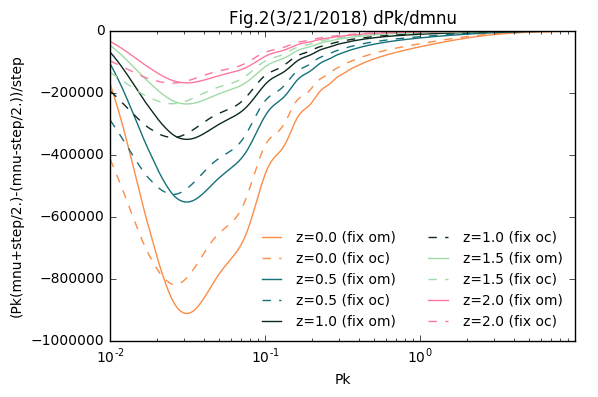

In [13]:
f,ax=subplots(1,1,figsize=(6,4))
seed(45)
for i in range(len(zcamb)):
    icolor=rand(3)
    ax.plot(kh, ds_fixom[i],'-',color=icolor,label='z=%s (fix om)'%(zcamb[i]))
    ax.plot(kh, ds_fixoc[i],'--',color=icolor,label='z=%s (fix oc)'%(zcamb[i]))
ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim(200,1e4)
#ax.set_ylim(-1e-9,0.5e-10)
ax.legend(loc=0,frameon=0,fontsize=10,ncol=2)
ax.set_xlabel('Pk')
ax.set_ylabel('(Pk(mnu+step/2.)-(mnu-step/2.))/step')
ax.set_title('Fig.2(3/21/2018) dPk/dmnu')
show()

In [272]:
######### using my old Fisher code
#ngal_arr = array([8.83154075745,13.2459963296,11.1471697714,7.3641882868,4.26106360488])
#Clnn =  array([0.35**2 / ngal / 1.18e7 for ngal in ngal_arr]).reshape(-1,1,1)

idx=where( (ps_fidu_avg[0]!=0) & (ell_fidu[0]<5000.0) )[0]
Nl = len(idx)

ps2 = swapaxes(ps_fidu[:,:,idx],0,1)
cov_mat = cov(ps2.reshape(1000,-1), rowvar=0) #* (2e4/12.25)
cov_inv = mat(cov_mat).I
#print ps_fidu.shape, ps2.shape
#print 'cov.shape',cov_mat.shape
#print dcldmnu_jia.shape, dcldom_jia.shape, dcldAs_jia.shape

d1 = mat(dcldmnu_jia[:,idx].flatten())
d2 = mat(dcldom_jia[:,idx].flatten())
d3 = mat(dcldAs_jia[:,idx].flatten())
dd = [d1,d2,d3]

Fisher = zeros(shape=(3,3))
for i in range(3):
    for j in range(3):
        M = dd[i].T*dd[j] + dd[j].T*dd[i]#Na.T*Nb
        Fisher[i,j] = 0.5 * trace(cov_inv*M)
err = sqrt(mat(Fisher).I)[[0,1,2],[0,1,2]]/sqrt(2e4/12.25)
print err

[ 0.00498983+0.j  0.00053611+0.j  0.00565960+0.j]


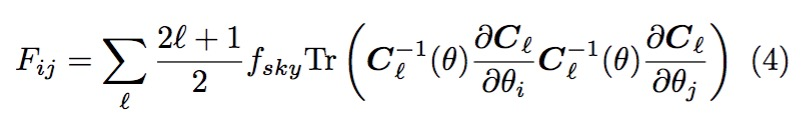

In [273]:
######### using the fisher formula Mat sent me
Image("Fisherfrommat.jpg")

In [274]:
####### using Mat's code https://arxiv.org/pdf/1402.4108.pdf
ellF = ell_fidu[0,idx]#.flatten()
ClF = ps_fidu_avg[:,idx]#.flatten()).I
ddF = array([dcldmnu_jia[:,idx],dcldom_jia[:,idx],dcldAs_jia[:,idx]])
print ellF.shape, ClF.shape, ddF.shape

dell = zeros(Nl)
dell[1:] = ell_fidu[0][idx][1:]-ell_fidu[0][idx][:-1]
dell[0]=dell[1]

#print ell_fisher.shape, Cell_fisher.shape
fsky=0.5
Fisher_mat = zeros(shape=(3,3))
for i in range(3):
    for j in range(3):
        Fell = 0   
        for ie in arange(len(ellF)):
            iCl = mat(ClF[:,ie]).I
            #print iCl
            d1, d2 = mat(ddF[i,:,ie]), mat(ddF[j,:,ie])
            
            Fell += (2.*ellF[ie]+1.)/2*fsky*trace(iCl*d1*iCl*d2) * dell[ie]
           
        Fisher_mat[i,j] = Fell
        #Fisher_mat[i,j] = sum( (2.0*ellF+1.0)/2.0*fsky*trace(ClFI*dd[i]*ClFI*dd[j])*dell_arr)
        
err_mat = sqrt(mat(Fisher_mat).I)[[0,1,2],[0,1,2]]
print err_mat

(26,) (5, 26) (3, 5, 26)
[ 0.03113056+0.j  0.00277921+0.j  0.01907053+0.j]


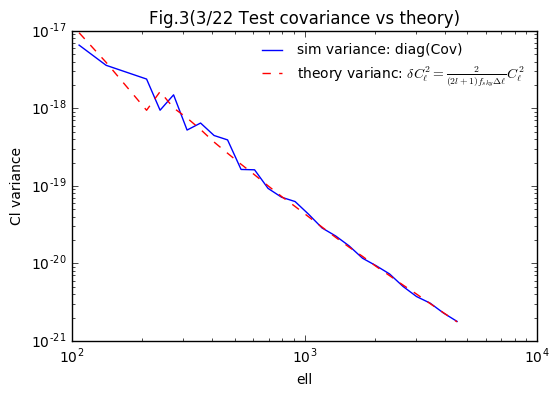

In [285]:
############# using only 1 redshift bins

id1, id2, id3 = ddF[0][0], ddF[1][0], ddF[2][0] ## ddF shape (3, 5, 47)
iCl = ps_fidu_avg[0,idx]## shape (5, 50)
fsim = 3.5**2/4e4

iCov = cov(ps_fidu[0,:,idx],rowvar=1) # ps+fidu shape (5, 1000, 50), iCov shape (47, 47)
loglog(ellF, diag(iCov),'b-',label='sim variance: diag(Cov)')
loglog(ellF, 1/(0.5*(2*ellF+1)*dell*fsim)*iCl**2, 'r--', 
       label=r'theory varianc: $\delta C_\ell^2=\frac{2}{(2l+1)f_{sky}\Delta\ell}C_\ell^2$')
title('Fig.3(3/22 Test covariance vs theory)')
xlabel('ell')
ylabel('Cl variance')
legend(fontsize=10,loc=0,frameon=0)
show()

In [284]:
print ellF.shape, dell.shape, iCl.shape, 

(26,) (26,) (5, 1) (26,)


In [286]:
####### test with only 1 redshift bins
## prepare all the necessary elements
## (1) zero out the off diagonal components
iCov_diag = zeros(shape=iCov.shape)
iCov_diag[diag_indices(len(id1))] = diag(iCov)

## (1b) zero out off diag, use theory variance
iCov_diagT = zeros(shape=iCov.shape)
iCov_diagT[diag_indices(Nl)] = 2/((2*ellF+1)*fsim*dell)*iCl**2

## (2) inverse covariance matrix
iCovI = mat(iCov).I
iCovdiagI = mat(iCov_diag).I
iCovdiagTI = mat(iCov_diagT).I
#print id1.shape, id2.shape, iCl.shape,iCov.shape

weight_mat = 0.5*(2*ellF+1)*fsim*dell
F_mat11 = sum( weight_mat *id1*id1/iCl**2)
F_jia11 = trace(iCovI*mat(id1).T*mat(id1))
F_jia11diag = trace(iCovdiagI*mat(id1).T*mat(id1))
F_jia11diagT = trace(iCovdiagTI*mat(id1).T*mat(id1))

print '''Fisher test 1 redsfhit (z=0.5), only 1 derivative dCell/dMnu, fky=12.25/4e4
(1) %.4f: Using Mat's method (Tegmark eq 16)
(2) %.4f: Jia Method (Tegmark eq 15 only 2nd term), using theory variance
(3) %.4f: Jia Method, using simulation variance
(4) %.4f: Jia Method, Using full covariance
'''%(1/sqrt(F_mat11),1/sqrt(F_jia11diagT), 1/sqrt(F_jia11diag), 1/sqrt(F_jia11))

Fisher test 1 redsfhit (z=0.5), only 1 derivative dCell/dMnu, fky=12.25/4e4
(1) 0.6402: Using Mat's method (Tegmark eq 16)
(2) 0.6402: Jia Method (Tegmark eq 15 only 2nd term), using theory variance
(3) 0.7039: Jia Method, using simulation variance
(4) 0.8134: Jia Method, Using full covariance



Fisher test 1 redsfhit (z=0.5), only 1 derivative dCell/dMnu, fky= 0.5
    (1) [ 0.05597756  0.00458403  0.04735754]: Using Mat's method (Tegmark eq 16)
    (2) [ 0.05597756  0.00458403  0.04735754]: Jia Method (Tegmark eq 15 only 2nd term), using theory variance
    (3) [ 0.05187917  0.00417242  0.04849544]: Jia Method, using simulation variance
    (4) [ 0.049627    0.00401109  0.04563238]: Jia Method, Using full covariance
    


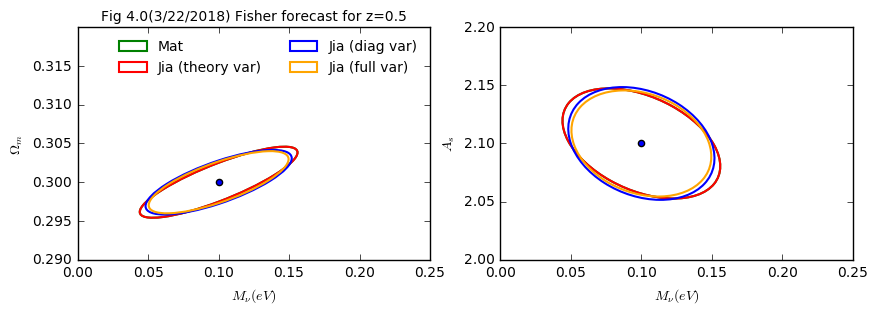

Fisher test 1 redsfhit (z=0.5), only 1 derivative dCell/dMnu, fky= 0.5
    (1) [ 0.0373221   0.00339414  0.0269242 ]: Using Mat's method (Tegmark eq 16)
    (2) [ 0.0373221   0.00339414  0.0269242 ]: Jia Method (Tegmark eq 15 only 2nd term), using theory variance
    (3) [ 0.03680845  0.00329967  0.02748621]: Jia Method, using simulation variance
    (4) [ 0.03473921  0.00306853  0.02565362]: Jia Method, Using full covariance
    


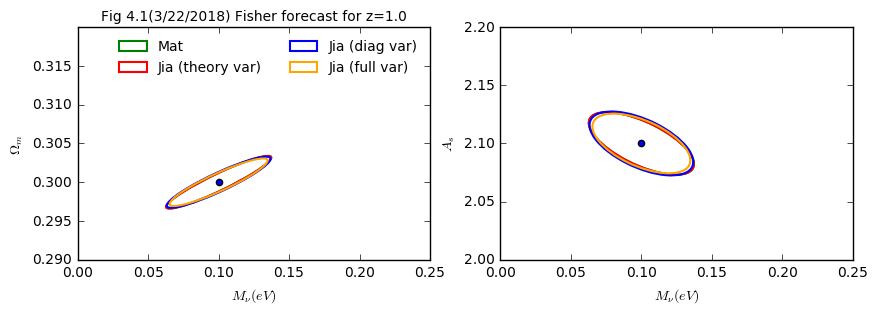

Fisher test 1 redsfhit (z=0.5), only 1 derivative dCell/dMnu, fky= 0.5
    (1) [ 0.03245215  0.00284122  0.02071578]: Using Mat's method (Tegmark eq 16)
    (2) [ 0.03245215  0.00284122  0.02071578]: Jia Method (Tegmark eq 15 only 2nd term), using theory variance
    (3) [ 0.03484881  0.00301956  0.0216602 ]: Jia Method, using simulation variance
    (4) [ 0.03360078  0.00291644  0.02107899]: Jia Method, Using full covariance
    


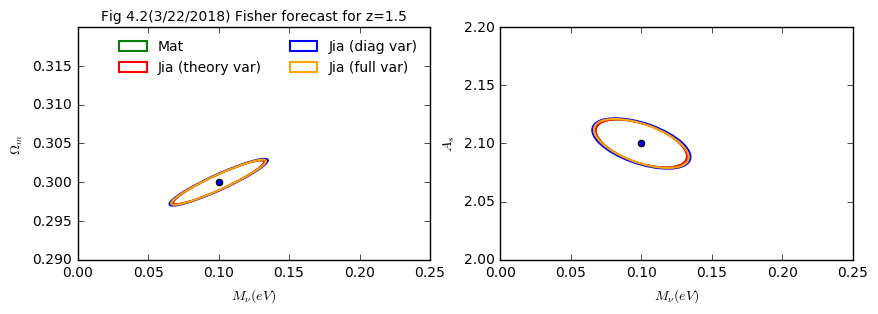

Fisher test 1 redsfhit (z=0.5), only 1 derivative dCell/dMnu, fky= 0.5
    (1) [ 0.02820094  0.00254392  0.01759189]: Using Mat's method (Tegmark eq 16)
    (2) [ 0.02820094  0.00254392  0.01759189]: Jia Method (Tegmark eq 15 only 2nd term), using theory variance
    (3) [ 0.03221306  0.00289045  0.01909387]: Jia Method, using simulation variance
    (4) [ 0.03119376  0.00280707  0.01869863]: Jia Method, Using full covariance
    


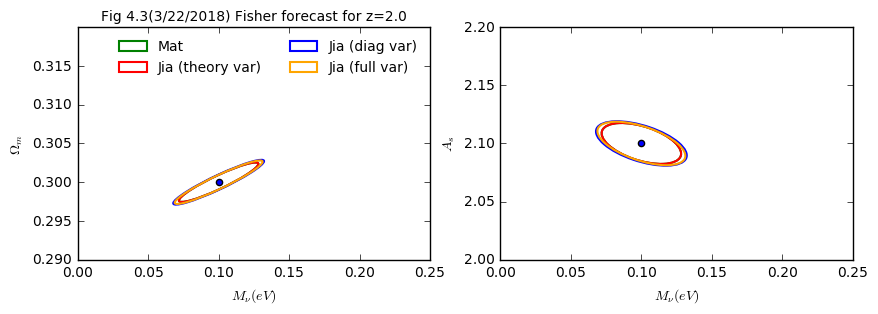

Fisher test 1 redsfhit (z=0.5), only 1 derivative dCell/dMnu, fky= 0.5
    (1) [ 0.02897051  0.00259259  0.01730961]: Using Mat's method (Tegmark eq 16)
    (2) [ 0.02897051  0.00259259  0.01730961]: Jia Method (Tegmark eq 15 only 2nd term), using theory variance
    (3) [ 0.03344196  0.00294509  0.01858638]: Jia Method, using simulation variance
    (4) [ 0.03228967  0.0028439   0.01818727]: Jia Method, Using full covariance
    


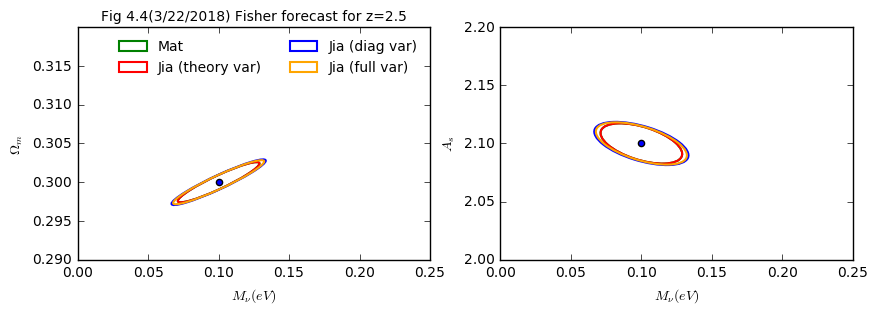

In [269]:
###### now move on to 3 parameters
Ferr = lambda Fisher_mat: real(sqrt(mat(Fisher_mat).I)[[0,1,2],[0,1,2]]) 
Ferr_diag = lambda Fisher_mat: real(1/sqrt(diag(Fisher_mat)))
fsim = 3.5**2/4e4
#weight_mat = 0.5*(2*ellF+1)*fsim*dell

for nn in range(5):
    id1, id2, id3 = ddF[0][nn], ddF[1][nn], ddF[2][nn] ## ddF shape (3, 5, 47)
    iCl = ps_fidu_avg[nn,idx]## shape (5, 50)
      
    iCov = cov(ps_fidu[nn,:,idx],rowvar=1) # ps+fidu shape (5, 1000, 50), iCov shape (47, 47)
    iCov_diag = zeros(shape=iCov.shape)
    iCov_diag[diag_indices(len(id1))] = diag(iCov)
    iCov_diagT = zeros(shape=iCov.shape)
    iCov_diagT[diag_indices(len(id1))] = 2/((2*ellF+1)*fsim*dell)*iCl**2

    iCovI = mat(iCov).I
    iCovdiagI = mat(iCov_diag).I
    iCovdiagTI = mat(iCov_diagT).I
    
    dd_arr = [id1, id2, id3]
    F_matz05 = zeros(shape=(3,3))
    F_jiadiagTz05 = zeros(shape=(3,3))
    F_jiadiagz05 = zeros(shape=(3,3))
    F_jiafullz05 = zeros(shape=(3,3))
    for i in range(3):
        for j in range(3):
            dA = dd_arr[i]
            dB = dd_arr[j]
            F_matz05 [i,j] = sum(weight_mat *dA*dB/iCl**2)
            Mij = mat(dA).T*mat(dB) + mat(dB).T*mat(dA)  
            F_jiadiagTz05 [i,j]= 0.5*trace(iCovdiagTI*Mij)
            F_jiadiagz05 [i,j]= 0.5*trace(iCovdiagI*Mij)
            F_jiafullz05 [i,j]= 0.5*trace(iCovI* Mij)

    Flist = array( [F_matz05, F_jiadiagTz05, F_jiadiagz05, F_jiafullz05]) / (12.5/2e4)
    Ferr_out = ([Ferr(imat) for imat in Flist])
    print '''Fisher test 1 redsfhit (z=0.5), only 1 derivative dCell/dMnu, fky= 0.5
    (1) %s: Using Mat's method (Tegmark eq 16)
    (2) %s: Jia Method (Tegmark eq 15 only 2nd term), using theory variance
    (3) %s: Jia Method, using simulation variance
    (4) %s: Jia Method, Using full covariance
    '''% (Ferr_out[0], Ferr_out[1], Ferr_out[2], Ferr_out[3])
    
    
    f, (ax1,ax2) = subplots(1,2,figsize=(10,3))
    ax1.scatter(0.1, 0.3)
    ax2.scatter(0.1, 2.1)

    jjj=0
    labels=['Mat','Jia (theory var)', 'Jia (diag var)', 'Jia (full var)']
    for iF in Flist:
        icolor=['g','r','b','orange'][jjj]
        ilabel=labels[jjj]
        plotEllipse([0.1, 0.3], mat(iF).I[[0,1],:][:,[0,1]] ,icolor,'solid',ilabel,ax1)
        plotEllipse([0.1, 2.1], mat(iF).I[[0,2],:][:,[0,2]] ,icolor,'solid',ilabel,ax2)
        jjj+=1
    ax1.set_xlim(0.0,0.25)
    ax1.set_ylim(0.29,0.32)
    ax2.set_xlim(0.0,0.25)
    ax2.set_ylim(2,2.2)
    ax1.set_xlabel(r'$M_\nu(eV)$')
    ax1.set_ylabel(r'$\Omega_m$')
    ax2.set_xlabel(r'$M_\nu(eV)$')
    ax2.set_ylabel(r'$A_s$')
    ax1.legend(fontsize=10,frameon=0,ncol=2)
    ax1.set_title('Fig 4.%i(3/22/2018) Fisher forecast for z=%s'%(nn,z_source[nn]),fontsize=10)
    show()

In [357]:
###### now move on to 5 redshifts
copyarray = lambda x, times: repeat(x.reshape(1,-1),times,axis=0).flatten()
#ps_fidu = array([load('powerspectrum_noisy/%s_PS_50_z%02d.npy'%(fidu_cosmo,iz*10))[1:]  for iz in z_source])
ps_fidu_10k = array([load('powerspectrum_cov/%s_PS_50_z%02d_cov.npy'%(fidu_cosmo,iz*10))[int(iz*2000):int((iz+0.5)*2000)]  for iz in z_source])

dd5_arr = [iarr[:,idx] for iarr in [dcldmnu_jia, dcldom_jia, dcldAs_jia]]
Cl5 = ps_fidu_avg[:,idx]##
Cl5f = Cl5.flatten()
dd5_flat = [idd.flatten() for idd in dd5_arr] ## flatten the derivative array
ps2 = swapaxes(ps_fidu_10k[:,:,idx],0,1)
Cov5 = cov(ps2.reshape(1000,-1) ,rowvar=0)
weightmat5 = copyarray(weight_mat,5)
## (1) zero out the off diagonal components
## (1b) zero out off diag, use theory variance
Cov5_diagT = zeros(shape=Cov5.shape)
Cov5_diag = zeros(shape=Cov5.shape)
Cov5_diag1 = zeros(shape=Cov5.shape)
Cov5_diag1[diag_indices(Nl*5)] = Cov5 [diag_indices(Nl*5)]

for j in arange(5):
    for k in arange(5):
        for i in arange(Nl):
            Cov5_diag [j*Nl+i,k*Nl+i] = Cov5[j*Nl+i,k*Nl+i]
            Cov5_diagT[j*Nl+i,k*Nl+i] = 2/((2*ellF[i]+1)*fsim*dell[i])*Cl5[j,i]*Cl5[k,i]

## (2) inverse covariance matrix
Cov5I = mat(Cov5).I
Cov5diagI = mat(Cov5_diag).I
Cov5diag1I = mat(Cov5_diag1).I
#Cov5diagTI = mat(Cov5_diagT).I

## (3) Fisher matrices
F_mat = zeros(shape=(3,3))
F_jiadiagT = zeros(shape=(3,3))
F_jiadiag = zeros(shape=(3,3))
F_jiadiag1 = zeros(shape=(3,3))
F_jiafull = zeros(shape=(3,3))
F_mat_cross = zeros(shape=(3,3))
for i in range(3):
    for j in range(3):
        dA, dAf = dd5_arr[i], dd5_flat[i]
        dB, dBf = dd5_arr[j], dd5_flat[j]
        for k in range(len(weight_mat)):
            iweight = weight_mat[k]
            littlecov = mat(Cl5[:,k]).I
            F_mat_cross [i,j] += iweight*trace(littlecov*mat(dA[:,k])*littlecov*mat(dB[:,k]))
            #F_mat [i,j] +=  sum(iweight*dA[:,k]*dB[:,k]/Cl5[:,k]**2)
        F_mat [i,j] = sum(weightmat5 * dAf * dBf / Cl5f**2)
        Mij = mat(dAf).T*mat(dBf) + mat(dBf).T*mat(dAf)  
        #F_jiadiagT [i,j]= 0.5*trace(CovdiagTI*Mij)
        F_jiadiag [i,j]= 0.5*trace(Cov5diagI*Mij)
        F_jiadiag1 [i,j]= 0.5*trace(Cov5diag1I*Mij)
        F_jiafull [i,j]= 0.5*trace(Cov5I* Mij)        
            
Flist5 = array( [F_mat, F_jiadiag1, F_jiadiag, F_jiafull, F_mat_cross]) / (12.5/2e4)
Ferr5_out = ([Ferr(imat) for imat in Flist5])
print '''Fisher test 5 redsfhits, fky= 0.5
(1) %s: Mat method (Tegmark eq 16), NO CROSS POWER BETWEEN REDSHIFTS!
(2) %s: Jia Method, using only self variance
(3) %s: Jia Method, using self & cross variance
(4) %s: Jia Method, Using full covariance
(5) %s: Mat (with cross power)
'''% (Ferr5_out[0], Ferr5_out[1], Ferr5_out[2],Ferr5_out[3],Ferr5_out[4])

#print dA[:,k].shape
#print dot(littlecov,dA[:,k].reshape(1,5))-littlecov*mat(dA[:,k])

Fisher test 5 redsfhits, fky= 0.5
(1) [ 0.01334554  0.00118714  0.00911395]: Mat method (Tegmark eq 16), NO CROSS POWER BETWEEN REDSHIFTS!
(2) [ 0.01391517  0.00122952  0.00939095]: Jia Method, using only self variance
(3) [ 0.01381025  0.00122565  0.00942265]: Jia Method, using self & cross variance
(4) [ 0.01348705  0.00121775  0.00924665]: Jia Method, Using full covariance
(5) [ 0.03144662  0.00280743  0.01926414]: Mat (with cross power)



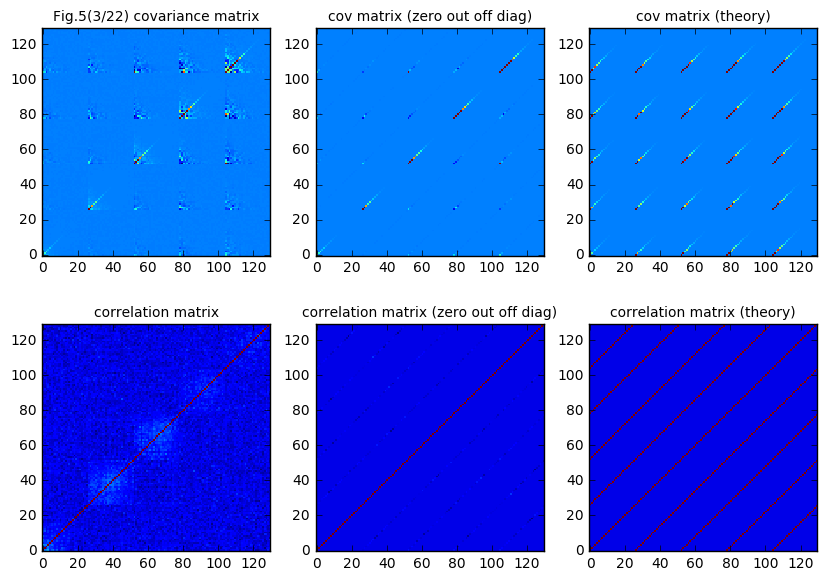

In [358]:
f, ((ax1,ax2, ax3),(ax1b,ax2b, ax3b))=subplots(2,3,figsize=(10,7))
istd=std(Cov5)
ax1.imshow(Cov5,origin='lower', vmin=-istd, vmax=3*istd, interpolation='nearest')
ax1.set_title('Fig.5(3/22) covariance matrix', fontsize=10)
ax2.imshow(Cov5_diag,origin='lower', vmin=-istd, vmax=3*istd, interpolation='nearest')
ax2.set_title('cov matrix (zero out off diag)', fontsize=10)
ax3.imshow(Cov5_diagT,origin='lower', vmin=-istd, vmax=3*istd, interpolation='nearest')
ax3.set_title('cov matrix (theory)', fontsize=10)

ax1b.imshow(WLanalysis.corr_mat(Cov5),origin='lower', interpolation='nearest',vmin=-0.1, vmax=1)
ax1b.set_title('correlation matrix', fontsize=10)
ax2b.imshow(WLanalysis.corr_mat(Cov5_diag),origin='lower', interpolation='nearest',vmin=-0.1, vmax=1)
ax2b.set_title('correlation matrix (zero out off diag)', fontsize=10)
ax3b.imshow(WLanalysis.corr_mat(Cov5_diagT),origin='lower', interpolation='nearest',vmin=-0.1, vmax=1)
ax3b.set_title('correlation matrix (theory)', fontsize=10)
show()

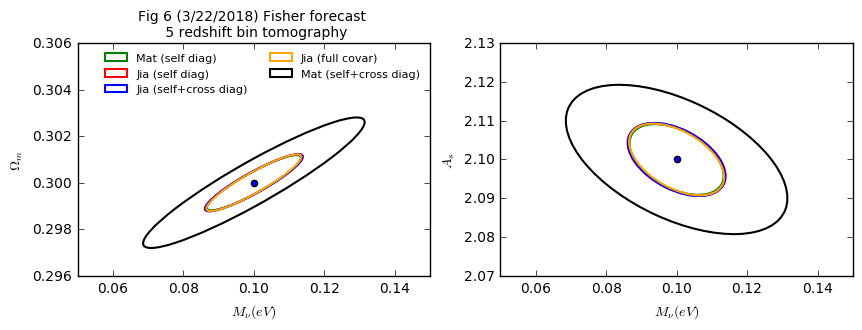

In [359]:
f, (ax1,ax2) = subplots(1,2,figsize=(10,3))
ax1.scatter(0.1, 0.3)
ax2.scatter(0.1, 2.1)

jjj=0
labels=['Mat (self diag)', 'Jia (self diag)', 'Jia (self+cross diag)', 'Jia (full covar)', 'Mat (self+cross diag)']
for iF in Flist5:
    icolor=['g','r','b','orange','k'][jjj]
    ilabel=labels[jjj]
    plotEllipse([0.1, 0.3], mat(iF).I[[0,1],:][:,[0,1]] ,icolor,'solid',ilabel,ax1)
    plotEllipse([0.1, 2.1], mat(iF).I[[0,2],:][:,[0,2]] ,icolor,'solid',ilabel,ax2)
    jjj+=1
ax1.set_xlim(0.05,0.15)
ax1.set_ylim(0.296,0.306)
ax2.set_xlim(0.05,0.15)
ax2.set_ylim(2.07,2.13)
ax1.set_xlabel(r'$M_\nu(eV)$')
ax1.set_ylabel(r'$\Omega_m$')
ax2.set_xlabel(r'$M_\nu(eV)$')
ax2.set_ylabel(r'$A_s$')
ax1.legend(fontsize=8,frameon=0,ncol=2)
ax1.set_title('Fig 6 (3/22/2018) Fisher forecast \n 5 redshift bin tomography',fontsize=10)
show()